##Data entry and cleaning

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
# Load the CSV file
data_df = pd.read_csv('/content/drive/MyDrive/Scenario-B-merged_5s.csv')
data_df.columns = data_df.columns.str.strip()

# Clean the data (to remove the infinite and NaN values from the dataset)
data_df = data_df.replace([np.inf, -np.inf], np.nan)
data_df.dropna(inplace=True)

# Filter labels of interest
desired_labels = ['VOIP', 'VIDEO', 'FILE-TRANSFER', 'CHAT', 'BROWSING']
data_df = data_df[data_df['label'].isin(desired_labels)]
data_df.shape

(10845, 29)

##Functions for Data pre-processing

In [ ]:
# Define a function to extract numerical features
def extract_numerical_features(df):
    numerical_features = df.select_dtypes(include=[np.number])
    #print("These are numerical features \n",numerical_features.head(1))
    return numerical_features

# Group packets into Packet Blocks
def aggregate_packets(df, block_size):
    grouped = df.groupby(['Source IP', 'Source Port', 'Destination IP', 'Destination Port', 'Protocol'])
    #groupby command return (name, group)
    #name contains the values of 'Source IP', 'Source Port', 'Destination IP', 'Destination Port', 'Protocol'
    #group is a subset of the dataset that stores the value corresponding to the name
    packet_blocks = []
    labels = []

    # Lists to store the first five entries of name and group
    name_list = []
    group_list = []

    for name, group in grouped:
        # Store the first five names and groups
        if len(name_list) < 5:
            name_list.append(name)
            group_list.append(group.head(2))  # Store only the first few rows of the group

        packets = extract_numerical_features(group).values
        for i in range(0, len(packets), block_size): #range(Starting_point, ending_point, intercept)
            block = packets[i:i + block_size]
            if len(block) == block_size:
                packet_blocks.append(block.flatten())
                labels.append(group['label'].iloc[0])

    # Print the first five names and groups
    print("Top 5 Names:")
    for n in name_list:
        print(n)

    print("\nTop 5 Groups:")
    for g in group_list:
        print(g)
    print(len(labels))
    return np.array(packet_blocks), np.array(labels)


##Printing the values of top 5 entries in the group and name

In [ ]:

K = 50  # It is the aggregation degree thus can be used as the block size
packet_blocks, labels = aggregate_packets(data_df, K)

Top 5 Names:
('10.0.2.15', 33071, '195.154.126.78', 443, 6)
('10.0.2.15', 33308, '195.154.126.78', 443, 6)
('10.0.2.15', 33827, '82.161.239.177', 110, 6)
('10.0.2.15', 34328, '198.52.200.39', 443, 6)
('10.0.2.15', 34361, '5.9.123.81', 9001, 6)

Top 5 Groups:
      Source IP  Source Port  Destination IP  Destination Port  Protocol  \
3095  10.0.2.15        33071  195.154.126.78               443         6   
3113  10.0.2.15        33071  195.154.126.78               443         6   

      Flow Duration  Flow Bytes/s  Flow Packets/s  Flow IAT Mean  \
3095        1107532  17962.460678       34.310521   29933.297297   
3113         391763  13564.323328       30.630764   35614.818182   

      Flow IAT Std  ...  Bwd IAT Min  Active Mean  Active Std  Active Max  \
3095  62747.732625  ...            5            0           0           0   
3113  60733.911802  ...          192            0           0           0   

      Active Min  Idle Mean  Idle Std  Idle Max  Idle Min     label  
3095 

##Print the shape and the 1st value of the labels and packet_blocks

In [ ]:
print(labels[10])
print(labels.shape)
print(packet_blocks.shape)
#as each iteration is flattened thus block_size * column_number here 50 * 26 = 1300 (not counting source port, destination port, labels)
print(packet_blocks[10])
#this shows that One packet block has one label

FILE-TRANSFER
(201,)
(201, 1300)
[3.6629e+04 4.4300e+02 6.0000e+00 ... 0.0000e+00 0.0000e+00 0.0000e+00]


In [ ]:
# Normalize the features in between (0,1)
scaler = MinMaxScaler()
packet_blocks_scaled = scaler.fit_transform(packet_blocks)
packet_blocks_scaled.shape

(201, 1300)

In [ ]:
# Calculate the number of features
total_features = packet_blocks_scaled.shape[1]
total_features

1300

In [ ]:
# Ideally, M and N should be such that M * N = total_features
M = 3000//K
N = 60
M,N

(60, 60)

In [ ]:
# ideally M * N is at least equal to total_features
packet_blocks_padded = np.pad(packet_blocks_scaled, ((0, 0), (0, M * N - total_features)), 'constant')
#np.pad(array, pad_width, mode) here "constant" means 0
#(0, 0) for the first axis: No padding is applied to the rows (first axis).
#(0, M * N - total_features) for the second axis: This pads the columns (second axis) to ensure each block has exactly
# M * N features, filling with zeros if needed.


# Reshape the features into M * N dimensions
packet_images = packet_blocks_padded.reshape((-1, M, N))
#After reshaping, the total number of elements must remain the same. So, NumPy will calculate the size of the -1 dimension as:
#inferred_dimension = total_Elements / (M * N)

In [ ]:
# Convert labels to categorical format
labels_encoded = pd.factorize(labels)[0]
#factorize converts the character labels to numeric values
#.factorize() returns two labels one teh original and other the converted and we want the converted thus [0]

labels_categorical = to_categorical(labels_encoded)
#to_categorical is used for one-hot encoding (transforms categorical labels into binary vectors)

labels_categorical.shape,labels_encoded.shape

((201, 5), (201,))

In [ ]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(packet_images, labels_categorical, test_size=0.2, random_state=42)

# Save the preprocessed data
np.save('X_train.npy', X_train)
np.save('X_test.npy', X_test)
np.save('y_train.npy', y_train)
np.save('y_test.npy', y_test)

## Retreating the saved files

In [ ]:
# Model and training
import numpy as np
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Load the preprocessed data
X_train = np.load('X_train.npy')
X_test = np.load('X_test.npy')
y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')
X_train.shape

(160, 60, 60)

##Sample image and data stored in the column

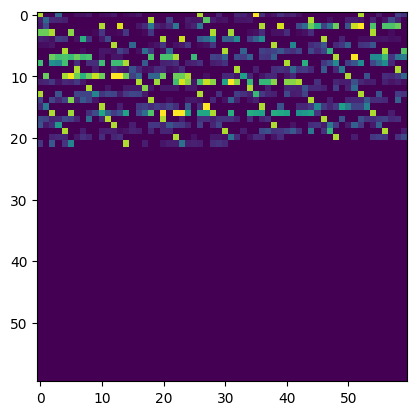

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(X_train[20].reshape((M, N)))
plt.show()

In [ ]:
X_train.shape,X_train[1]

((160, 60, 60),
 array([[6.68033140e-01, 6.05135474e-03, 0.00000000e+00, ...,
         1.01985518e-03, 3.19718481e-02, 1.54241928e-02],
        [2.09813753e-02, 1.76245211e-01, 2.85406024e-02, ...,
         4.61162129e-04, 1.46029412e-02, 1.17024715e-02],
        [3.10596345e-02, 4.09237124e-04, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]))

##Model creation

In [ ]:

# Define the 1D CNN model
def create_cnn_model(input_shape, num_classes):
    model = Sequential()

    # First Convolutional Layer
    model.add(Conv1D(5, kernel_size=6, strides=1, padding='same', activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=3))

    # Second Convolutional Layer
    model.add(Conv1D(10, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=3))

    # Flatten and Dense Layers
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    return model
#Convulation layer: filters=5: Number of output filters in the convolution.
#kernel_size This filter slides over the input data and performs a dot product with the input values within the kernel's length.
#strides specifies the step size with which the filter moves across the input data. It determines how many elements the filter shifts each time it moves.
#Activation function applied after the convolution (Rectified Linear Unit).
# parameter (in Convolution layer) = (kernel_size * kernel_size * number of input channel +1) * number of output channel
# parameter (in dense layer) = (input_no._of_neurons +1) * output_no._of_nuerons
input_shape = (M, N)  # Adjust the input shape accordingly
num_classes = y_train.shape[1]  # Number of classes

model = create_cnn_model(input_shape, num_classes)
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
input_shape,num_classes

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 60, 5)               │           1,805 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 20, 5)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 20, 10)              │             260 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 6, 10)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 60)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           3,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,294 (24.59 KB)

 Trainable params: 6,294 (24.59 KB)

 Non-trainable params: 0 (0.00 B)

((60, 60), 5)

## Model training

In [ ]:
# Train the model
history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=50,
                    validation_split=0.2)

# Evaluate on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc:.4f}')

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.0771 - loss: 1.6875 - val_accuracy: 0.0312 - val_loss: 1.6063
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1771 - loss: 1.6189 - val_accuracy: 0.4375 - val_loss: 1.5531
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3115 - loss: 1.5603 - val_accuracy: 0.5312 - val_loss: 1.5062
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3625 - loss: 1.5229 - val_accuracy: 0.5625 - val_loss: 1.4627
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4781 - loss: 1.4732 - val_accuracy: 0.5938 - val_loss: 1.4110
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4417 - loss: 1.4528 - val_accuracy: 0.6250 - val_loss: 1.3507
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5177 - loss: 1.3809 - val_accuracy: 0.6562 - val_loss: 1.2875
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5562 - loss: 1.3390 - val_accuracy: 0.7188 - val_loss: 1.2218


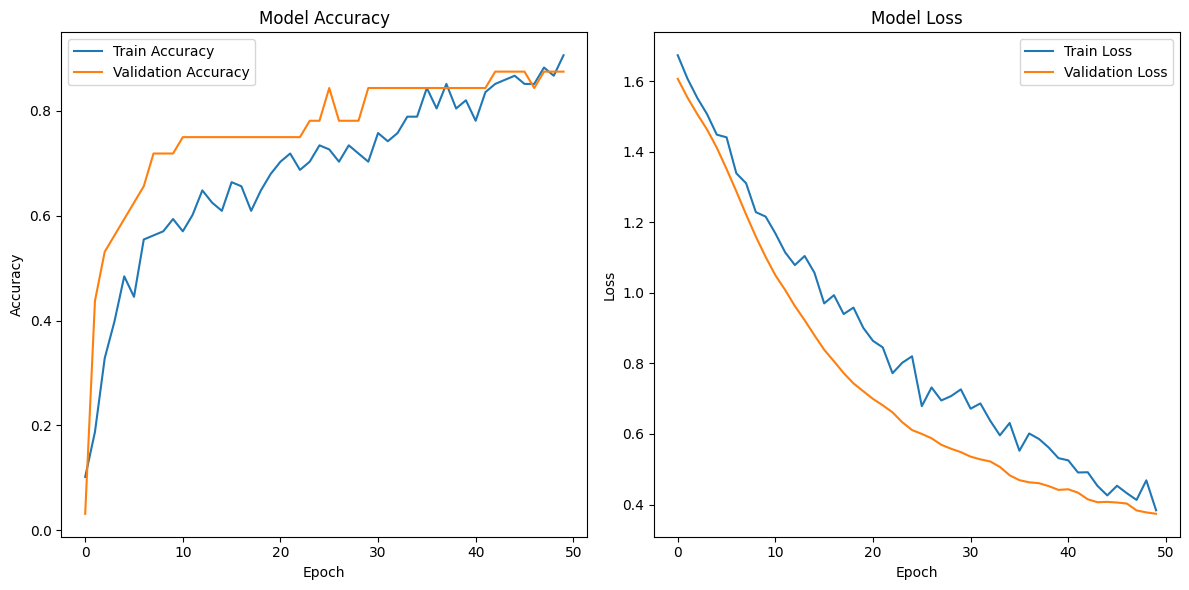

In [ ]:

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')

plt.tight_layout()
plt.show()
